In [1]:
import pandas as pd
from topics_api_simulator.simulator import Simulator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Topics API simulator

In this notebook, we illustrate how to compute the probability of a user being $k$-anonymous and the probability of re-identification. Please refer to code documentation and to the paper for any additional detail.

In [2]:
# the dataset to be used as input
# as a starting point, a user x topic matrix is used
# each cell contains the average visiting rate in an epoch for every user and topic
# at the moment, we assume visiting rates to be stationary
DF = pd.read_csv('lambda-user-topic.csv').values

#default parameters for the simulation
params = {
    'nusers': 1000,
    'z': 5,
    'nepochs': 40,
    'p': .05,
    'T': 349,
    'pmin': 1e-5,
    'method': 'iid'
}

seeds = [1,32,345,85,347,128,24,729,283,90]

## $Prob(k-anon)$

The module can be used to evaluate the probability of a user being $k$-anonymous among the users that visited a website. The Topics API and environment parameters can be tuned to observe the evolution in the $Prob(k-anon)$. In the following example, we use the $k$ itself.

In [3]:
methods = ['iid','crossover']
# define a range of ks
ks = range(2,11)

pkanons_per_seed = []
# for every seed
for seed in tqdm(seeds):
    pkanons_per_method = []
    # for both the methods
    for method in methods:
        
        params['method'] = method
        sim = Simulator(DF, params, seed=seed)
        
        pkanons_per_k = []
        for k in ks:
            
            pkanons = sim.get_prob_kanon(k=k)
            pkanons_per_k.append(pkanons)
        
        pkanons_per_method.append(pkanons_per_k)
        
    pkanons_per_seed.append(pkanons_per_method)
    
pkanons_per_seed = np.array(pkanons_per_seed)

100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


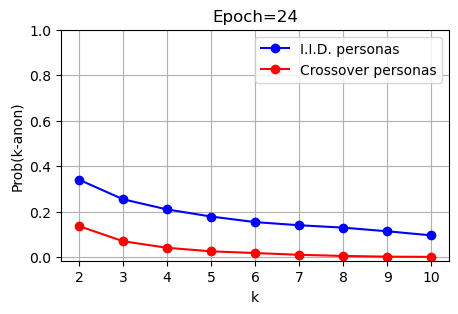

In [4]:
epoch = 24
plt.figure(figsize=(5,3))
plt.title(f'Epoch={epoch}')
plt.xlabel('k')
plt.ylabel('Prob(k-anon)')
plt.plot(ks, pkanons_per_seed.mean(axis=0)[0,:,epoch], marker='o', c='b', label='I.I.D. personas')
plt.plot(ks, pkanons_per_seed.mean(axis=0)[1,:,epoch], marker='o', c='r', label='Crossover personas')
plt.ylim(top=1.)
plt.legend()
plt.grid()
plt.show()

## $Prob(re-identification)$

The model can also be used to estimate directly the probability of a user to be re-identified by an attacker using two colluding websites.

### Strict attack
In this section, the attack is simple: if a website contains a unique denoised reconstructed profile that matches with another unique profile on the other website, this is considered to be a match.

In [5]:
methods = ['iid','crossover']

tps_per_seed = []
fps_per_seed = []
# for every seed
for seed in tqdm(seeds):
    tps_per_method = []
    fps_per_method = []
    # for each of the two methods
    for method in methods:
        
        params['method'] = method
        sim = Simulator(DF, params, seed=seed)
        #return both the correct (tp) and incorrect (fp) matches
        tp,fp = sim.get_reconstruction_prob()

        tps_per_method.append(tp)
        fps_per_method.append(fp)
        
    tps_per_seed.append(tps_per_method)
    fps_per_seed.append(fps_per_method)
    
tps_per_seed = np.array(tps_per_seed)
fps_per_seed = np.array(fps_per_seed)

100%|██████████| 10/10 [01:00<00:00,  6.01s/it]


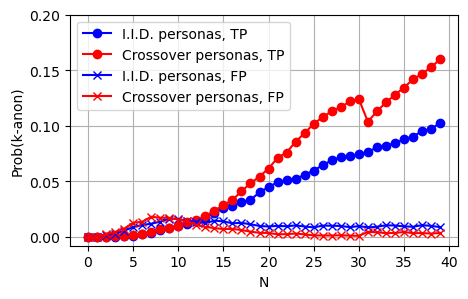

In [6]:
plt.figure(figsize=(5,3))
plt.xlabel('N')
plt.ylabel('Prob(k-anon)')
plt.plot(tps_per_seed.mean(axis=0)[0], marker='o', c='b', label='I.I.D. personas, TP')
plt.plot(tps_per_seed.mean(axis=0)[1], marker='o', c='r', label='Crossover personas, TP')
plt.plot(fps_per_seed.mean(axis=0)[0], marker='x', c='b', label='I.I.D. personas, FP')
plt.plot(fps_per_seed.mean(axis=0)[1], marker='x', c='r', label='Crossover personas, FP')
plt.ylim(top=.2)
plt.legend()
plt.grid()
plt.show()

### Loose attack

In this section, the attack is slightly more complicatd: to have a match, the denoised reconstructed profile on the first website must be a subset of the global reconstructed profile on the second website, and viceversa. The two denoised profiles must be unique in each website.

To reduce the number of false positives, we introduce a temporal coincidence analysis. Please refer to the code for details.

In [7]:
methods = ['iid','crossover']

tps_per_seed = []
fps_per_seed = []
# for every seed
for seed in tqdm(seeds):
    tps_per_method = []
    fps_per_method = []
    # for each of the two methods
    for method in methods:
        
        params['method'] = method
        sim = Simulator(DF, params, seed=seed)
        #return both the correct (tp) and incorrect (fp) matches
        tp,fp = sim.get_reconstruction_prob_loose()

        tps_per_method.append(tp)
        fps_per_method.append(fp)
        
    tps_per_seed.append(tps_per_method)
    fps_per_seed.append(fps_per_method)
    
tps_per_seed = np.array(tps_per_seed)
fps_per_seed = np.array(fps_per_seed)

100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


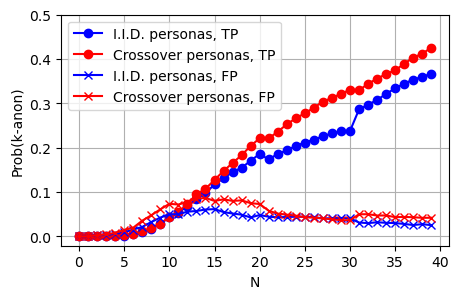

In [8]:
plt.figure(figsize=(5,3))
plt.xlabel('N')
plt.ylabel('Prob(k-anon)')
plt.plot(tps_per_seed.mean(axis=0)[0], marker='o', c='b', label='I.I.D. personas, TP')
plt.plot(tps_per_seed.mean(axis=0)[1], marker='o', c='r', label='Crossover personas, TP')
plt.plot(fps_per_seed.mean(axis=0)[0], marker='x', c='b', label='I.I.D. personas, FP')
plt.plot(fps_per_seed.mean(axis=0)[1], marker='x', c='r', label='Crossover personas, FP')
plt.ylim(top=.5)
plt.legend()
plt.grid()
plt.show()